In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from matplotlib.pylab import rcParams
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
rcParams['figure.figsize'] =15, 6
import seaborn as sns
sns.set()

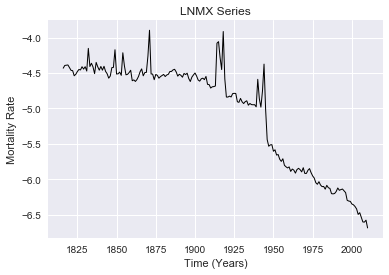

In [2]:
lnmx = pd.read_csv("lnmx_series.csv",index_col="Year")
lnmx = lnmx["40"]
lnmx = lnmx[lnmx.index<2011]

plt.plot(lnmx,linewidth=1,color="k")
plt.xlabel("Time (Years)")
plt.ylabel("Mortality Rate")
plt.title("LNMX Series")
plt.show()

In [3]:
split= 1990

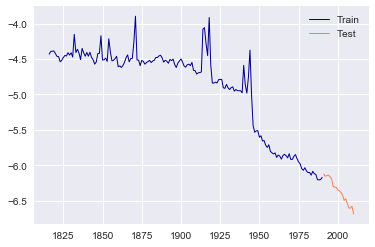

In [4]:
Train, Test = lnmx[lnmx.index<=split] ,lnmx[lnmx.index>split] # Train and Test series
plt.plot(Train,color="darkblue",linewidth=1,label="Train")
plt.plot(Test,color="coral",linewidth=1,label="Test")
plt.legend()
plt.show()

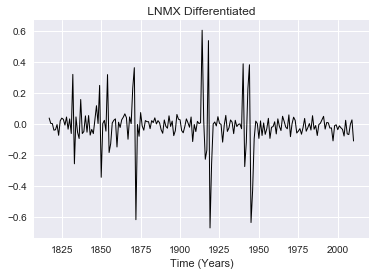

In [5]:
lnmx_diff = lnmx.diff().dropna()
plt.plot(lnmx_diff,c="k",linewidth=1)
plt.xlabel("Time (Years)")
plt.title(" LNMX Differentiated ")
plt.show()

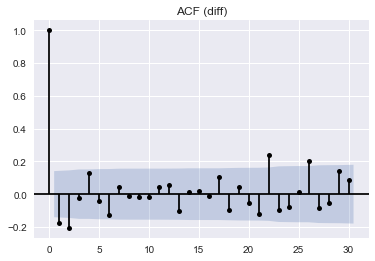

In [6]:
plot_acf(lnmx_diff, lags=30, c="k")
plt.title("ACF (diff)")
plt.show()

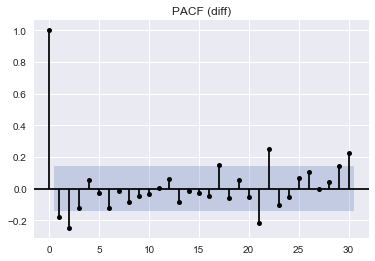

In [7]:
plot_pacf(lnmx_diff, lags=30, c= "k")
plt.title("PACF (diff)")
plt.show()

/Users/filipeduarte/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/filipeduarte/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/filipeduarte/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/filipeduarte/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/filipeduarte/anaconda3/lib/python3.6/site

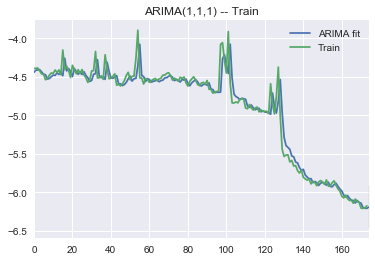

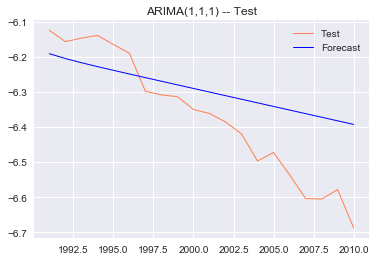

MSE ARIMA Train (diff. serie)=  0.01895676155281437
MSE ARIMA Test=  0.01866295662810095


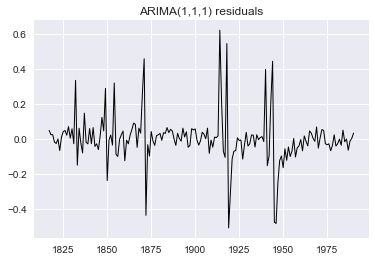

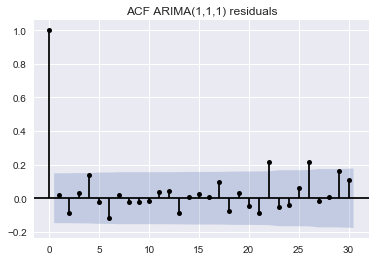

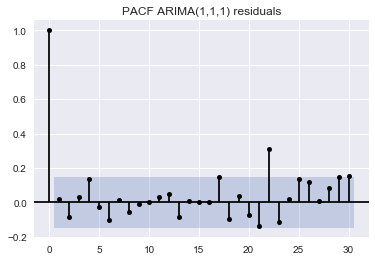

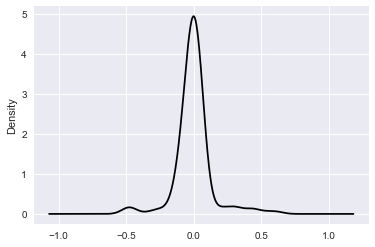

                0
count  174.000000
mean     0.000275
std      0.138081
min     -0.507001
25%     -0.040193
50%     -0.002874
75%      0.037690
max      0.619916


In [8]:
model = ARIMA(Train, order=(1, 1, 1))
fitted = model.fit(disp=0)
# Forecast
fc, se, conf = fitted.forecast(len(Test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)
arima_fittedValues = fitted.fittedvalues
# Plot
fitted.plot_predict(dynamic=False,start=1,end=len(Train))
plt.title("ARIMA(1,1,1) -- Train")
plt.legend(['ARIMA fit', 'Train' ])
plt.show()


plt.plot(Test,label="Test",color="coral",linewidth=1)
plt.plot(fc_series, label='Forecast',color="blue",linewidth=1)
plt.title("ARIMA(1,1,1) -- Test")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('Test')
L.get_texts()[1].set_text('Forecast')
plt.show()


# MSE
mse_arima_train = mean_squared_error(lnmx_diff[lnmx_diff.index<=split], arima_fittedValues)
print("MSE ARIMA Train (diff. serie)= ", mse_arima_train)
mse_arima = mean_squared_error(Test, fc_series)
print("MSE ARIMA Test= ", mse_arima)
#print(fitted.summary())
#plot residual errors
residuals = pd.DataFrame(fitted.resid)
plt.plot(residuals,color='k',linewidth=1)
plt.title("ARIMA(1,1,1) residuals")
plt.show()
plot_acf(residuals,color="k",lags=30)
plt.title("ACF ARIMA(1,1,1) residuals")
plt.show()
plot_pacf(residuals,color="k",lags=30)
plt.title("PACF ARIMA(1,1,1) residuals")
plt.show()
residuals.plot(kind='kde',color='k').get_legend().remove()
plt.show()
print(residuals.describe())

In [9]:
serie = lnmx

In [10]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()


def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [11]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]

    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)

    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x

    lags_selecionados = []

    for i in range(1, max_lag+1):


        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0

    #caso nenhum lag seja selecionado, essa atividade de seleção
    # para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

# Criando os conjuntos de treinamento, validação e teste
def divisao_dados_temporais(X,y, perc_treino, perc_val = 0):
    tam_treino = int(perc_treino * len(y))
    
    if perc_val > 0:        
        tam_val = int(len(y)*perc_val)
              
        X_treino = X[0:tam_treino,:]
        y_treino = y[0:tam_treino,:]
        
        print("Particao de Treinamento:", 0, tam_treino)
        
        X_val = X[tam_treino:tam_treino+tam_val,:]
        y_val = y[tam_treino:tam_treino+tam_val,:]
        
        print("Particao de Validacao:",tam_treino,tam_treino+tam_val)
        
        X_teste = X[(tam_treino+tam_val):-1,:]
        y_teste = y[(tam_treino+tam_val):-1,:]
        
        print("Particao de Teste:", tam_treino+tam_val, len(y))
        
        return X_treino, y_treino, X_teste, y_teste, X_val, y_val
        
    else:
        
        X_treino = X[0:tam_treino,:]
        y_treino = y[0:tam_treino,:]

        X_teste = X[tam_treino:-1,:]
        y_teste = y[tam_treino:-1,:]

        return X_treino, y_treino, X_teste, y_teste 

In [12]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
# Criar as janelas com 20 saídas para y e 3 lags
values = list(serie)
data = series_to_supervised(values, 3, 20)
data.head()

,var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),...,var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19)
3,-4.431805,-4.393209,-4.389253,-4.386035,-4.425435,-4.462543,-4.466104,-4.538727,-4.518167,-4.479948,...,-4.444328,-4.411002,-4.472039,-4.151931,-4.408206,-4.362302,-4.415294,-4.508497,-4.350295,-4.411579
4,-4.393209,-4.389253,-4.386035,-4.425435,-4.462543,-4.466104,-4.538727,-4.518167,-4.479948,-4.449963,...,-4.411002,-4.472039,-4.151931,-4.408206,-4.362302,-4.415294,-4.508497,-4.350295,-4.411579,-4.459772
5,-4.389253,-4.386035,-4.425435,-4.462543,-4.466104,-4.538727,-4.518167,-4.479948,-4.449963,-4.456578,...,-4.472039,-4.151931,-4.408206,-4.362302,-4.415294,-4.508497,-4.350295,-4.411579,-4.459772,-4.407221
6,-4.386035,-4.425435,-4.462543,-4.466104,-4.538727,-4.518167,-4.479948,-4.449963,-4.456578,-4.411249,...,-4.151931,-4.408206,-4.362302,-4.415294,-4.508497,-4.350295,-4.411579,-4.459772,-4.407221,-4.459772
7,-4.425435,-4.462543,-4.466104,-4.538727,-4.518167,-4.479948,-4.449963,-4.456578,-4.411249,-4.444328,...,-4.408206,-4.362302,-4.415294,-4.508497,-4.350295,-4.411579,-4.459772,-4.407221,-4.459772,-4.405009


In [14]:
# Transformando em array
X, y = np.array(data.iloc[:,:3]), np.array(data.iloc[:,3:])
x_train, y_train, x_test, y_test, x_val, y_val = divisao_dados_temporais(X,y, perc_treino=0.6, perc_val = 0.29)

Particao de Treinamento: 0 103
Particao de Validacao: 103 153
Particao de Teste: 153 173


In [15]:
def treinar_mlp(x_train, y_train, x_val, y_val,num_exec):


    neuronios =  [1,2,3,5,10]  #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['tanh','relu']#['tanh']   #['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs','adam','sgd']#, 'sgd', 'adam']
    max_iteracoes = [10000] #[100, 1000, 10000]
    learning_rate = ['constant','adaptive']  #['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0])+1):
                        #variar a qtd de pontos utilizados na janela

                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i],
                             'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i],
                                 activation=func_activation[j], solver=alg_treinamento[l],
                                  max_iter = max_iteracoes[m], learning_rate= learning_rate[n])


                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag


    return select_model, qtd_lags_sel

In [16]:
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, 5)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 1.254189096730856
Melhor MSE: 1.254188570528074
Melhor MSE: 1.2541643710996202
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 1.254058249768653
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 1.2540359227654836
Melhor MSE: 1.2540335919777714
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1

In [17]:
modelo

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [21]:
lag_sel

2

In [22]:
predict_test = modelo.predict(Train.values[-lag_sel:].reshape(1,lag_sel)).reshape(20,)
predict_test = pd.Series(predict_test, index = Test.index)

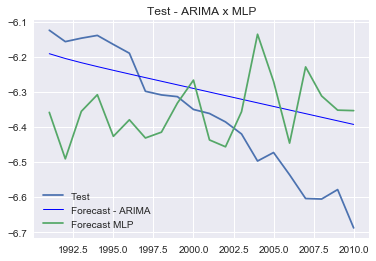

MSE Teste ARIMA = 0.136612432187195
MSE Teste MLP = 0.21974897824119458
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [23]:
plt.plot(Test, label='Test', color = "blue")
plt.plot(fc_series, label='Forecast - ARIMA',color="coral")
plt.plot(predict_test, label = 'Forecast MLP', color = "green")

plt.title("Test - ARIMA x MLP")
plt.legend(loc='best')
plt.show()

print("RMSE Teste ARIMA = %s" %np.sqrt(MSE(Test, fc_series)))
print("RMSE Teste MLP = %s" %np.sqrt(MSE(Test, predict_test)))
print(modelo)